# Постановка задачи

Пусть дан ориентированный граф $G = (V, E, L)$. Каждому пути $l = l_1, \dots, l_n$ в этом графе сопоставим слово $\omega(l) = m_1 \dots m_n$, полученное конкатенацией меток $m_i$, где $m_i$ -- метка ребра $l_i$. Также пусть даны два множества: $V_s \subseteq V$ -- множество стартовых вершин в графе и $V_f \subseteq V$ -- множество финальных вершин в графе.

Пусть через регулярное выражение задан регулярный язык $R$.

## Достижимость между всеми парами вершин

$\{ (v_s, v_f) \in V \times V : \exists l = v_s \pi v_f, ~\omega(l) \in R \}$

## Достижимость для каждой из заданного множества стартовых вершин

$\{ (v_s, v_f) \in V_s \times V_f : \exists l = v_s \pi v_f, ~\omega(l) \in R \}$

Целью эксперимента является получить ответ на следующие вопросы:

1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

# Описание исследуемых решений

## Достижимость между всеми парами вершин

Задача о достижимости между всеми парами вершин решается при помощи алгоритма на основе тензорного произведения матриц (`tensor_based_rpq`): по регулярному выражению и графу строятся два автомата на основе матриц смежности, при помощи тензорного произведения ищется пересечение этих автоматов и при помощи транзитивного замыкания полученного пересечения ищутся необходимые пары вершин.

## Достижимость для каждой из заданного множества стартовых вершин

Задача о достижимости для каждой из заданного множества стартовых вершин решается при помощи multiple source BFS алгоритма (`ms_bfs_based_rpq`): по регулярному выражению и графу строятся два автомата на основе матриц смежности, а затем по ним параллельно из всех стартовых вершин совершается обход в ширину.

# Описание набора данных для экспериментов

В качестве эспериментальных графов были выбраны следующие:
1. `skos`
2. `wc`
3. `generations`
4. `atom`

Выбор подобных графов обусловлен ограничениями тестового стенда.

Пронумеруем метки в графе таким образом, чтобы `m_1` обозначало самую частую, а `m_n` -- самую редкую метку. Тогда в качестве шаблонов для регулярных запросов были выбраны следующие:
1. `m_1 | m_2 | ... | m_n` -- все пути в графе длины 1
2. `(m_1 | m_2 | ... | m_n)*` -- все пути в графе
3. `m_1 . (m_1 | ... | m_n)* . m_n` -- пути, начинающиеся самой частой и заканчивающиеся самой редкой меткой
4. `(m_1 | m_2)* . ((m_1* . m_2*) | (m_2* . m_1*))`

Выбор запросов обусловлен тем, что они различаются по количеству состояний и переходов в конечном автомате, что влияет на размер и разреженность матрицы смежности.

В качестве рассматриваемых типов представления разреженной матрицы выбрались следующие:
1. `csr`
2. `csc`
3. `dok`

Выбор этих форматов разреженных матриц обусловлен тем, что только они поддерживают необходимые для работы описанных выше алгоритмов операции, к примеру как присваивание и взятие по индексу.

In [42]:
import networkx as nx
import pandas as pd
import numpy as np
import cfpq_data
import matplotlib.pyplot as plt
import seaborn as sns

from timeit import timeit

from utils import get_graph_info, load_graph
from regular.path_query import tensor_based_rpq, ms_bfs_based_rpq

In [2]:
def get_sorted_labels(graph: nx.MultiDiGraph):
    labels = {}
    for _, _, label in graph.edges.data("label"):
        labels[label] = labels.get(label, 0) + 1
    
    return sorted(labels.keys(), key=lambda label: labels[label], reverse=True)

In [3]:
graph_names = ["skos", "wc", "generations", "atom"]
sparse_types = ["csr", "csc", "dok"]

def get_regexes_by_graph(graph: nx.MultiDiGraph):
    labels = get_sorted_labels(graph)
    graph.edges
    return [
        "|".join(labels),
        f"({"|".join(labels)})*",
        f"{labels[0]}.({"|".join(labels)}).{labels[-1]}",
        f"({labels[0]}|{labels[1]})*.(({labels[0]}*.{labels[1]}*)|({labels[1]}*.{labels[0]}*))"
    ]

# Описание эксперимента

## Тестовый стенд

## Методология проведения эксперимента

### Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

Для каждого из алгоритмов и графов считалось среднее по 50 запускам время работы на различных типах разреженных матриц с регулярный запросом вида `(m_1 | m_2 | ... | m_n)*`. Затем для каждого типа разреженноы матриц считалось среднее время работы для всех проведенных замеров. В качестве стартовых и финальных вершин  выбирались все вершины графа.

### Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Для каждого алгоритма брался фиксированный тип разреженной матрицы (`csr`), затем для каждого типа регулярного выражения из описанных выше и для каждого графа считалось среднее время работы по 50 запускам для двух алгоритмов и считалась разность между `ms_bfs_based_rpq` и `tensor_based_rpq`. Для тех замеров, где эта разность оказывалась больше нуля, выгоднее было решать задачу для всех пар вершин.

# Эксперимент

In [4]:
NUM_RUNS = 40
RANDOM_SEED = 52

## Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

In [5]:
columns = ["graph"] + sparse_types

In [ ]:
results = {
    "tensors": {graph_name: [] for graph_name in graph_names},
    "ms_bfs": {graph_name: [] for graph_name in graph_names}
}

for graph_name in graph_names:
    graph = load_graph(graph_name)
    regex = get_regexes_by_graph(graph)[2]
    for sparse_type in sparse_types:
        print(sparse_type)
        times = {
            "tensors": [],
            "ms_bfs": []
        }
        for _ in range(NUM_RUNS):
            times["tensors"].append(timeit(lambda: tensor_based_rpq(regex, graph, sparse_format=sparse_type), number=1))
            times["ms_bfs"].append(timeit(lambda: ms_bfs_based_rpq(regex, graph, sparse_format=sparse_type), number=1))
        results["tensors"][graph_name].append((np.mean(times["tensors"]), np.std(times["tensors"])))
        results["ms_bfs"][graph_name].append((np.mean(times["ms_bfs"]), np.std(times["ms_bfs"])))

In [12]:
tensor_df = pd.DataFrame(
    [[graph_name] + list(map(lambda x: f"{x[0]:.3f} +- {x[1]:.3f}", res)) for graph_name, res in results["tensors"].items()],
    columns=columns
)

In [14]:
print("Результаты для tensor_based_rpq")
tensor_df

Результаты для tensor_based_rpq


,graph,csr,csc,dok
0,skos,2.233 +- 0.124,2.222 +- 0.106,2.215 +- 0.131
1,wc,37.203 +- 0.355,37.150 +- 0.176,37.095 +- 0.076
2,generations,2.273 +- 0.024,2.285 +- 0.022,2.278 +- 0.023
3,atom,8.454 +- 0.053,8.595 +- 0.027,8.507 +- 0.047


In [15]:
ms_bfs_df = pd.DataFrame(
    [[graph_name] + list(map(lambda x: f"{x[0]:.3f} +- {x[1]:.3f}", res)) for graph_name, res in results["ms_bfs"].items()],
    columns=columns
)

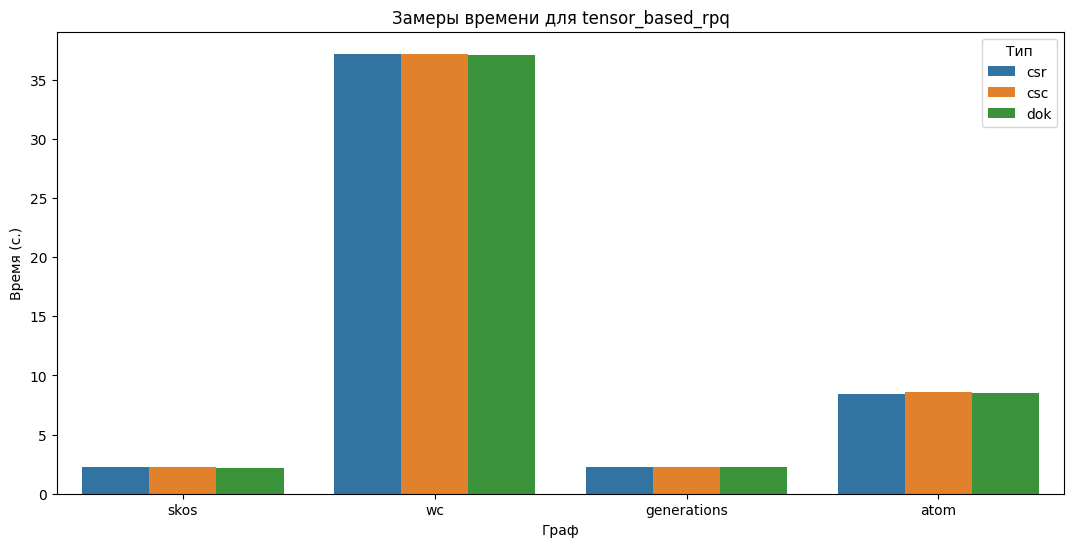

In [58]:
plot_tensor_df = pd.DataFrame(
    [[graph_name] + list(map(lambda x: x[0], res)) for graph_name, res in results["tensors"].items()],
    columns=columns
).melt(id_vars=["graph"], value_vars=sparse_types, var_name="type", value_name="value")


plt.figure(figsize=(13, 6))
sns.barplot(data=plot_tensor_df, x="graph", y="value", hue="type")
plt.xlabel('Граф')
plt.ylabel('Время (с.)')
plt.title('Замеры времени для tensor_based_rpq')
plt.legend(title='Тип')
plt.show()

In [16]:
print("Результаты для ms_bfs_based_rpq")
ms_bfs_df

Результаты для ms_bfs_based_rpq


,graph,csr,csc,dok
0,skos,1.029 +- 0.026,1.019 +- 0.042,1.190 +- 0.036
1,wc,0.514 +- 0.013,0.523 +- 0.016,0.614 +- 0.017
2,generations,1.364 +- 0.032,1.352 +- 0.031,1.617 +- 0.023
3,atom,1.626 +- 0.042,1.626 +- 0.050,1.945 +- 0.047


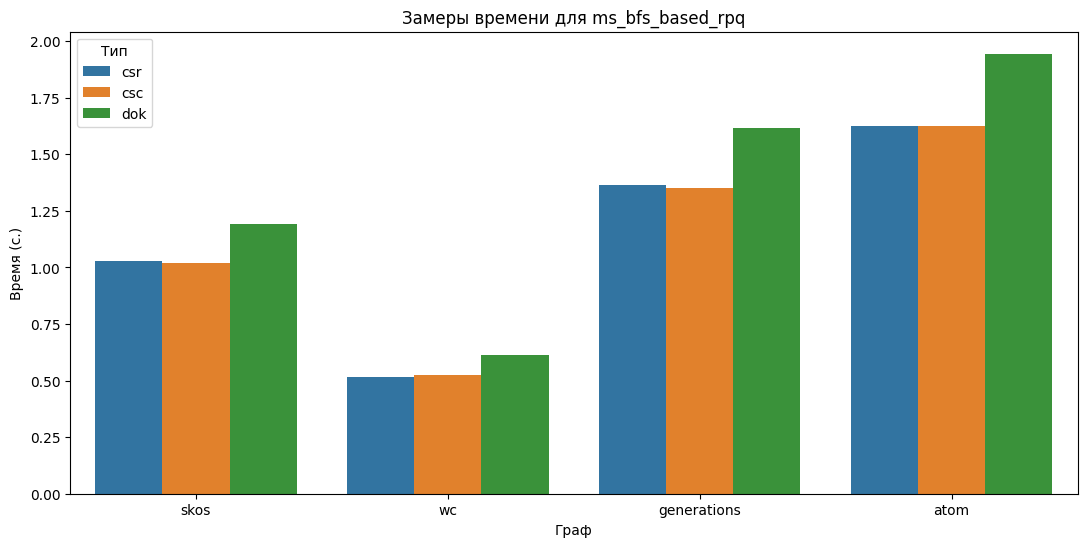

In [59]:
plot_ms_bfs_df = pd.DataFrame(
    [[graph_name] + list(map(lambda x: x[0], res)) for graph_name, res in results["ms_bfs"].items()],
    columns=columns
).melt(id_vars=["graph"], value_vars=sparse_types, var_name="type", value_name="value")


plt.figure(figsize=(13, 6))
sns.barplot(data=plot_ms_bfs_df, x="graph", y="value", hue="type")
plt.xlabel('Граф')
plt.ylabel('Время (с.)')
plt.title('Замеры времени для ms_bfs_based_rpq')
plt.legend(title='Тип')
plt.show()

Из таблиц и графиков видно, что для `tensor_based_rpq` не играет большой разницы, какой формат представления разреженной матрицы брать. Однако для `ms_bfs_based_rpq` представление в формате `dok` снижает производительность по отношению к `csr` и `csc`, поэтому не рекомендуется его использовать.